Process SRC (.src.gz & .sz used by DSI Studio) which contain raw DWI information

The .sz files first need to be unzipped and the extension renamed to .mat

In [4]:
import nibabel as nib
import scipy.io
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool

import compute_ADC

In [5]:
#mat_DATA_DIR = '/run/user/1001/gvfs/smb-share:server=sum-gin-nas.u-ga.fr,share=gin_equipe_05/PROJECTS/Current/2024_these_FEHR--DELUDE_Theotime/Databases/mat_Human_Connectome_Project_Young_Adult_HCP-YA'
mat_DATA_DIR = '/data_network/summer_projects/fehrdelt/Current/2024_these_FEHR--DELUDE_Theotime/Databases/mat_Human_Connectome_Project_Young_Adult_HCP-YA/'
nifti_DATA_DIR = '/data_network/summer_projects/fehrdelt/Current/2024_these_FEHR--DELUDE_Theotime/Databases/nifti_Human_Connectome_Project_Young_Adult_HCP-YA/'

In [6]:
def reconstruct_image(image_array, mask_img):
    final_img = np.zeros_like(mask_img)
    counter = 0

    for k in range(mask_img.shape[2]):
        for i in range(mask_img.shape[0]):
            for j in range(mask_img.shape[1]):
                if mask_img[i, j, k] == 1:
                    final_img[i, j, k] = image_array[counter]
                    counter += 1
    return final_img

### Final function

In [7]:
def reconstruct_ADC_nifti(params_list):
    filepath, outdirectory = params_list

    basename = os.path.basename(filepath)
    

    mat = scipy.io.loadmat(filepath)
    btable = mat['b_table']
    dimension = mat['dimension'][0]
    mask_img = mat['mask'].reshape(dimension[1], dimension[0], dimension[2])
    image_b0 = reconstruct_image(mat['image0'][0], mask_img)

    ADC_maps_direction = np.zeros((len(btable[1])-1, mask_img.shape[0], mask_img.shape[1], mask_img.shape[2]))

    for i, b_value in enumerate(tqdm(btable[0])):
        #print(b_value)
        if b_value == 0:
            continue
        else:
            ADC_map = compute_ADC.compute_adc(S_b0=image_b0, S_b=reconstruct_image(mat[f"image{i}"][0], mask_img), b_value=b_value)
            ADC_maps_direction[i-1,:,:,:] = ADC_map
    
    ADC_averaged_over_directions = np.mean(ADC_maps_direction, axis=0)
    ADC_averaged_over_directions[mask_img==1] = np.clip(ADC_averaged_over_directions[mask_img==1], -0.001, 0.0014)
    ADC_averaged_over_directions[mask_img==1] = (ADC_averaged_over_directions[mask_img==1]- np.min(ADC_averaged_over_directions[mask_img==1]))/(np.max(ADC_averaged_over_directions[mask_img==1])-np.min(ADC_averaged_over_directions[mask_img==1]))
    ADC_averaged_over_directions[mask_img==1] = ADC_averaged_over_directions[mask_img==1]*4000

    # Create a NIfTI image
    nifti_img = nib.Nifti1Image(ADC_averaged_over_directions, affine=np.eye(4))

    # Save the NIfTI image to a file
    nib.save(nifti_img, outdirectory+f'{basename[:-4]}.nii.gz')

In [8]:
file_list = os.listdir(mat_DATA_DIR)
launch_params = []

for file in file_list:
    if file.endswith('.mat'):
        launch_params.append([mat_DATA_DIR+file, nifti_DATA_DIR])


In [9]:
nb_files = len(launch_params)
nb_coeurs = 32

for i in range(nb_files//nb_coeurs):
    print("------------ new pool ------------")
    print(f"i={i}")
    with Pool() as pool:
        pool.map(reconstruct_ADC_nifti, launch_params[i*nb_coeurs:(i+1)*nb_coeurs])
    print("end of pool")

remaining_files = nb_files % nb_coeurs

if remaining_files > 0:
    print("------------ remaining pool ------------")
    with Pool() as pool:
        pool.map(reconstruct_ADC_nifti, launch_params[-remaining_files:])
    print("end of remaining pool")

------------ new pool ------------
i=0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:44<00:00,  4.59s/it]


end of pool
------------ new pool ------------
i=1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:34<00:00,  4.56s/it]


end of pool
------------ new pool ------------
i=2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:35<00:00,  4.56s/it]


end of pool
------------ new pool ------------
i=3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:33<00:00,  4.55s/it]


end of pool
------------ new pool ------------
i=4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:17<00:00,  4.49s/it]


end of pool
------------ new pool ------------
i=5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:16<00:00,  4.49s/it]


end of pool
------------ new pool ------------
i=6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [21:40<00:00,  4.80s/it]


end of pool
------------ new pool ------------
i=7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [21:16<00:00,  4.71s/it]


end of pool
------------ new pool ------------
i=8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:08<00:00,  4.46s/it]


end of pool
------------ new pool ------------
i=9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:13<00:00,  4.48s/it]


end of pool
------------ new pool ------------
i=10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:12<00:00,  4.47s/it]


end of pool
------------ new pool ------------
i=11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:14<00:00,  4.48s/it]


end of pool
------------ new pool ------------
i=12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:23<00:00,  4.51s/it]


end of pool
------------ new pool ------------
i=13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:15<00:00,  4.48s/it]


end of pool
------------ new pool ------------
i=14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:13<00:00,  4.48s/it]


end of pool
------------ new pool ------------
i=15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:17<00:00,  4.49s/it]


end of pool
------------ new pool ------------
i=16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:15<00:00,  4.49s/it]


end of pool
------------ new pool ------------
i=17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:19<00:00,  4.50s/it]


end of pool
------------ new pool ------------
i=18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:08<00:00,  4.46s/it]


end of pool
------------ new pool ------------
i=19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:10<00:00,  4.47s/it]


end of pool
------------ new pool ------------
i=20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:15<00:00,  4.49s/it]


end of pool
------------ new pool ------------
i=21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:17<00:00,  4.49s/it]


end of pool
------------ new pool ------------
i=22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:18<00:00,  4.50s/it]


end of pool
------------ new pool ------------
i=23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:18<00:00,  4.50s/it]


end of pool
------------ new pool ------------
i=24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:25<00:00,  4.52s/it]


end of pool
------------ new pool ------------
i=25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:09<00:00,  4.46s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:14<00:00,  4.48s/it]


end of pool
------------ new pool ------------
i=26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:20<00:00,  4.50s/it]


end of pool
------------ new pool ------------
i=27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:12<00:00,  4.47s/it]


end of pool
------------ new pool ------------
i=28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:13<00:00,  4.48s/it]


end of pool
------------ new pool ------------
i=29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:06<00:00,  4.45s/it]


end of pool
------------ new pool ------------
i=30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [20:09<00:00,  4.46s/it]


end of pool
------------ remaining pool ------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [19:46<00:00,  4.38s/it]


end of remaining pool


### Exploration

Get infos and variables inside the mat file


b_table[0] stores the b values\
b_table[1], b_table[2] and b_table[3] store the x,y,z values

In [104]:
#mat = scipy.io.loadmat("/home/rivage/Documents/"+'/100206.mat')
#mat = scipy.io.loadmat(mat_DATA_DIR+'100206.mat')
mat = scipy.io.loadmat(mat_DATA_DIR+'100307.mat')

#variables = scipy.io.whosmat("/home/rivage/Documents/"+'/100206.mat')
#variables = scipy.io.whosmat(mat_DATA_DIR+'100206.mat')
variables = scipy.io.whosmat(mat_DATA_DIR+'100307.mat')
print(variables)

[('dimension', (1, 3), 'double'), ('voxel_size', (1, 3), 'double'), ('version', (1, 1), 'double'), ('b_table', (4, 271), 'double'), ('mask', (25230, 145), 'double'), ('image0', (1, 658911), 'double'), ('image0.slope', (1, 1), 'double'), ('image0.inter', (1, 1), 'double'), ('image1', (1, 658911), 'double'), ('image1.slope', (1, 1), 'double'), ('image1.inter', (1, 1), 'double'), ('image2', (1, 658911), 'double'), ('image2.slope', (1, 1), 'double'), ('image2.inter', (1, 1), 'double'), ('image3', (1, 658911), 'double'), ('image3.slope', (1, 1), 'double'), ('image3.inter', (1, 1), 'double'), ('image4', (1, 658911), 'double'), ('image4.slope', (1, 1), 'double'), ('image4.inter', (1, 1), 'double'), ('image5', (1, 658911), 'double'), ('image5.slope', (1, 1), 'double'), ('image5.inter', (1, 1), 'double'), ('image6', (1, 658911), 'double'), ('image6.slope', (1, 1), 'double'), ('image6.inter', (1, 1), 'double'), ('image7', (1, 658911), 'double'), ('image7.slope', (1, 1), 'double'), ('image7.inter

In [105]:
btable = mat['b_table']
print(len(btable[0]))
print(btable[3][0])

271
0.0


In [106]:

unique_values, counts = np.unique(btable[0], return_counts=True)
btable_counts = dict(zip(unique_values, counts))
print(btable_counts)

{0.0: 1, 990.0: 11, 995.0: 32, 1000.0: 26, 1005.0: 21, 1985.0: 4, 1990.0: 21, 1995.0: 13, 2000.0: 22, 2005.0: 26, 2010.0: 4, 2980.0: 1, 2985.0: 14, 2990.0: 21, 2994.0: 1, 2995.0: 16, 3000.0: 14, 3005.0: 15, 3010.0: 8}


In [107]:
dimension = mat['dimension'][0]
print(dimension)

[145 174 145]


Get the brain mask

In [108]:
#mask_img = mat['mask'].reshape(174, 145,145)
mask_img = mat['mask'].reshape(dimension[1], dimension[0], dimension[2])

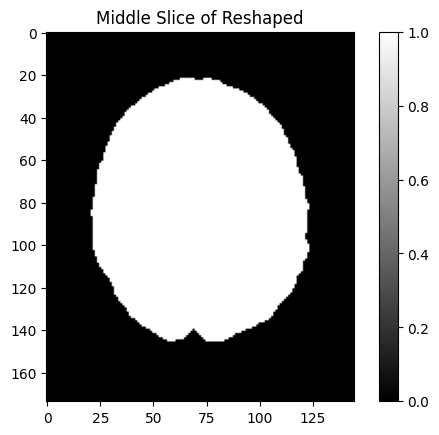

In [109]:
# Plot the middle slice
plt.imshow(mask_img[:, :, mask_img.shape[2] // 2], cmap='gray')
plt.title('Middle Slice of Reshaped')
plt.colorbar()
plt.show()

The diffusion values are stored only for voxels inside the mask this is why we need it to reconstruct the image

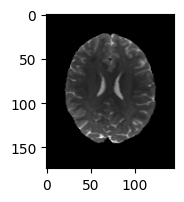

In [ ]:
image_b0 = reconstruct_image(mat['image0'][0], mask_img)

plt.figure(figsize=(2,2))
plt.imshow(image_b0[:, :, image_b0.shape[2] // 2], cmap='gray')
plt.show()

In [ ]:
ADC_maps_direction = np.zeros((len(btable[1])-1, mask_img.shape[0], mask_img.shape[1], mask_img.shape[2]))

for i, b_value in enumerate(tqdm(btable[0])):
    #print(b_value)
    if b_value == 0:
        continue
    else:
        ADC_map = compute_ADC.compute_adc(S_b0=image_b0, S_b=reconstruct_image(mat[f"image{i}"][0], mask_img), b_value=b_value)
        ADC_maps_direction[i-1,:,:,:] = ADC_map


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [18:54<00:00,  4.19s/it]


In [113]:
ADC_averaged_over_directions = np.mean(ADC_maps_direction, axis=0)

max: 0.004045373374851896
min: -0.016050604330758715


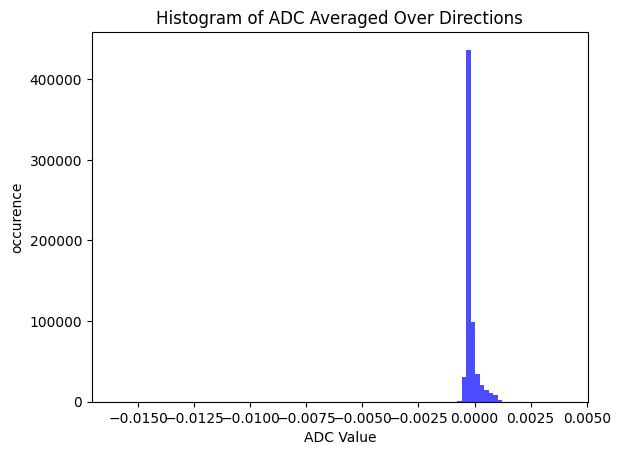

In [114]:
print(f"max: {np.max(ADC_averaged_over_directions)}")
print(f"min: {np.min(ADC_averaged_over_directions)}")

plt.hist(ADC_averaged_over_directions[mask_img==1].flatten(), bins=100, color='blue', alpha=0.7)
plt.title('Histogram of ADC Averaged Over Directions')
plt.xlabel('ADC Value')
plt.ylabel('occurence')
plt.show()

In [ ]:
#ADC_averaged_over_directions_norm = (ADC_averaged_over_directions - np.min(ADC_averaged_over_directions)) / (np.max(ADC_averaged_over_directions) - np.min(ADC_averaged_over_directions))

ADC_averaged_over_directions[mask_img==1] = np.clip(ADC_averaged_over_directions[mask_img==1], -0.001, 0.0014)


max: 0.0013
min: -0.001


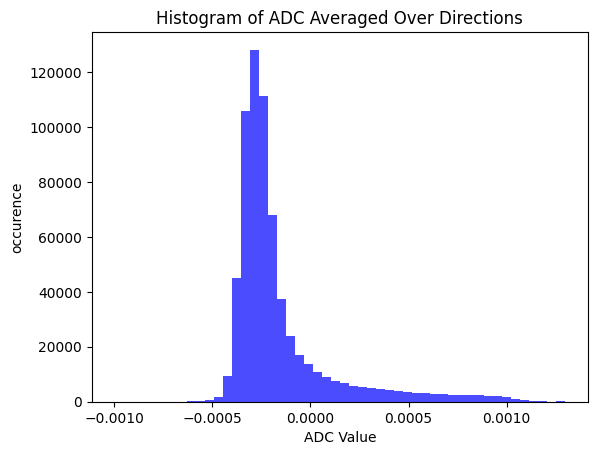

In [116]:
print(f"max: {np.max(ADC_averaged_over_directions)}")
print(f"min: {np.min(ADC_averaged_over_directions)}")

plt.hist(ADC_averaged_over_directions[mask_img==1].flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of ADC Averaged Over Directions')
plt.xlabel('ADC Value')
plt.ylabel('occurence')
plt.show()

In [117]:
ADC_averaged_over_directions[mask_img==1] = (ADC_averaged_over_directions[mask_img==1]- np.min(ADC_averaged_over_directions[mask_img==1]))/(np.max(ADC_averaged_over_directions[mask_img==1])-np.min(ADC_averaged_over_directions[mask_img==1]))

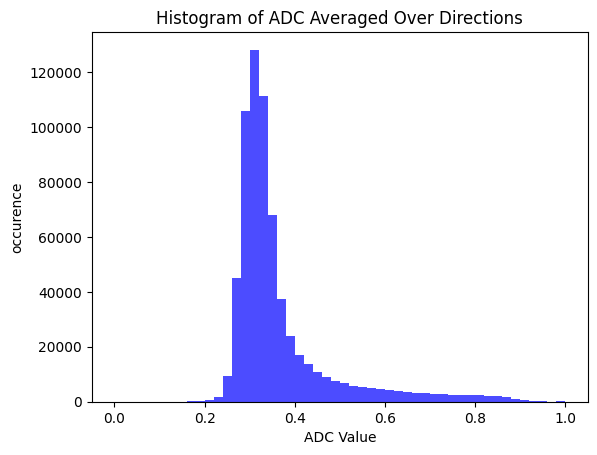

In [118]:
plt.hist(ADC_averaged_over_directions[mask_img==1].flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of ADC Averaged Over Directions')
plt.xlabel('ADC Value')
plt.ylabel('occurence')
plt.show()

In [119]:
ADC_averaged_over_directions[mask_img==1] = ADC_averaged_over_directions[mask_img==1]*4000

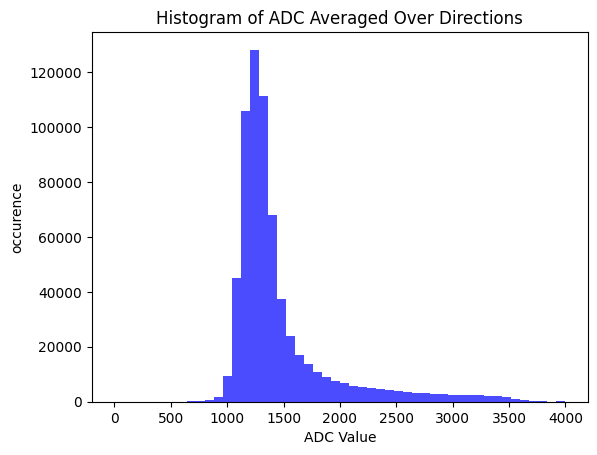

In [120]:
plt.hist(ADC_averaged_over_directions[mask_img==1].flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of ADC Averaged Over Directions')
plt.xlabel('ADC Value')
plt.ylabel('occurence')
plt.show()

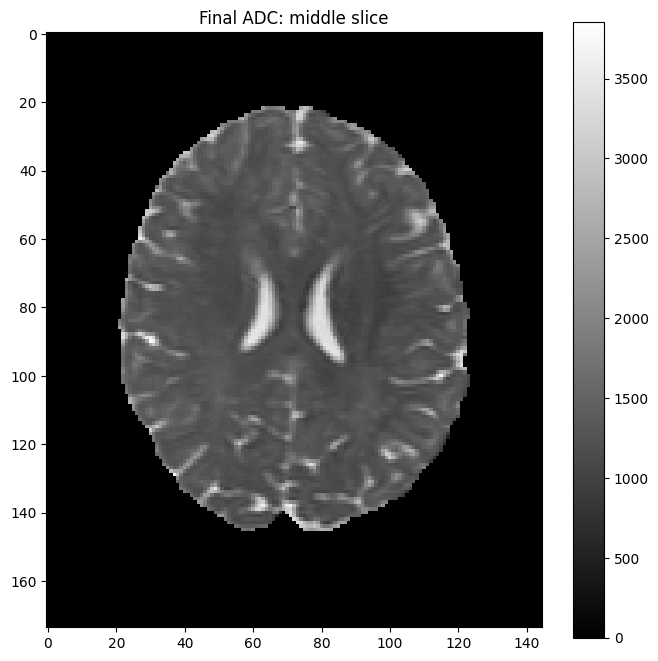

In [121]:
plt.figure(figsize=(8,8))
plt.imshow(ADC_averaged_over_directions[:, :, ADC_averaged_over_directions.shape[2] // 2], cmap='gray')
plt.title('Final ADC: middle slice')
plt.colorbar()
plt.show()

In [122]:
# Create a NIfTI image
nifti_img = nib.Nifti1Image(ADC_averaged_over_directions, affine=np.eye(4))

# Save the NIfTI image to a file
nib.save(nifti_img, nifti_DATA_DIR+'100307.nii.gz')